In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import nibabel as nb
from linescanning import *
from linescanning import glm,image,prf,utils
from scipy.io import loadmat
import matplotlib.pyplot as plt
import warnings
import matplotlib.patches as patches
import cortex
import seaborn as sns
import os

opj = os.path.join
base, place = utils.get_base_dir()

base_dir = opj(base, 'projects', 'linePlanning')
fig_dir = opj(base_dir, 'code', 'figures')

# ignore warnings
warnings.simplefilter("ignore")

In [4]:
def get_shift(arr1,arr2,vox_range=[-15,15], plot=False):

    """
get_shift

Obtain shift in line direction between 'real' and 'predicted' slice. 

Args:

    <arr1>      :np.ndarray
                array containing the average across the beam of the 'real' slice
    

    <arr2>      :np.ndarray
                array containing the average across the beam of the 'predicted' slice

Returns:
    shift in voxel dimensions, list of correlations across range, the range of voxels
    used for correlation
    """
    
    corr_vals = []
    range_vox = np.linspace(*vox_range, endpoint=True).astype(int)
    for ii in range_vox:

        pad_real = np.zeros(abs(ii))

        if ii > 0:
            pad_real = np.append(pad_real, arr1)
        else:
            pad_real = np.append(arr1,pad_real)

        pad_real = pad_real[:arr1.shape[0]]
        
        corr = np.corrcoef(arr2,pad_real)[0,1]
        corr_vals.append(corr)
        
    if plot:
        fig,axs = plt.subplots(figsize=(6,6))
        axs.plot(range_vox,corr_vals, color=mdd_color)
        axs.set_xlabel("Nr padded voxels").set_fontsize(14)
        axs.set_ylabel("correlation between 'real' and 'predicted'").set_fontsize(14)
        sns.despine(offset=10)

    max_corr = np.amax(corr_vals)
    vox_pad_ix = utils.find_nearest(corr_vals, max_corr)[0]
    print(f"max correlation = {max_corr.round(2)}; padding of {range_vox[vox_pad_ix]} voxels")

    pad_real = np.zeros(abs(range_vox[vox_pad_ix]))

    if range_vox[vox_pad_ix] > 0:
        pad_real = np.append(pad_real, real_line_avg)
    else:
        pad_real = np.append(real_line_avg, pad_real)
        
    pad_real = pad_real[:real_line_avg.shape[0]]

    if plot:
        glm.plot_array([pred_line_avg,pad_real], figsize=(20,5))

    return range_vox[vox_pad_ix],corr_vals,range_vox

/data1/projects/MicroFunc/Jurjen/projects/linePlanning/derivatives/confirm/sub-006/sub-006_ses-2_acq-1slice_run-1_orig_T2w.nii.gz
/data1/projects/MicroFunc/Jurjen/projects/linePlanning/derivatives/confirm/sub-006/sub-006_ses-2_acq-1slice_run-2_orig_T2w.nii.gz
/data1/projects/MicroFunc/Jurjen/projects/linePlanning/derivatives/confirm/sub-006/sub-006_ses-2_acq-1slice_run-3_orig_T2w.nii.gz
/data1/projects/MicroFunc/Jurjen/projects/linePlanning/derivatives/confirm/sub-006/sub-006_ses-2_acq-1slice_run-4_orig_T2w.nii.gz
/data1/projects/MicroFunc/Jurjen/projects/linePlanning/derivatives/confirm/sub-006/sub-006_ses-2_acq-1slice_run-5_orig_T2w.nii.gz
/data1/projects/MicroFunc/Jurjen/projects/linePlanning/derivatives/confirm/sub-006/sub-006_ses-2_acq-1slice_run-6_orig_T2w.nii.gz


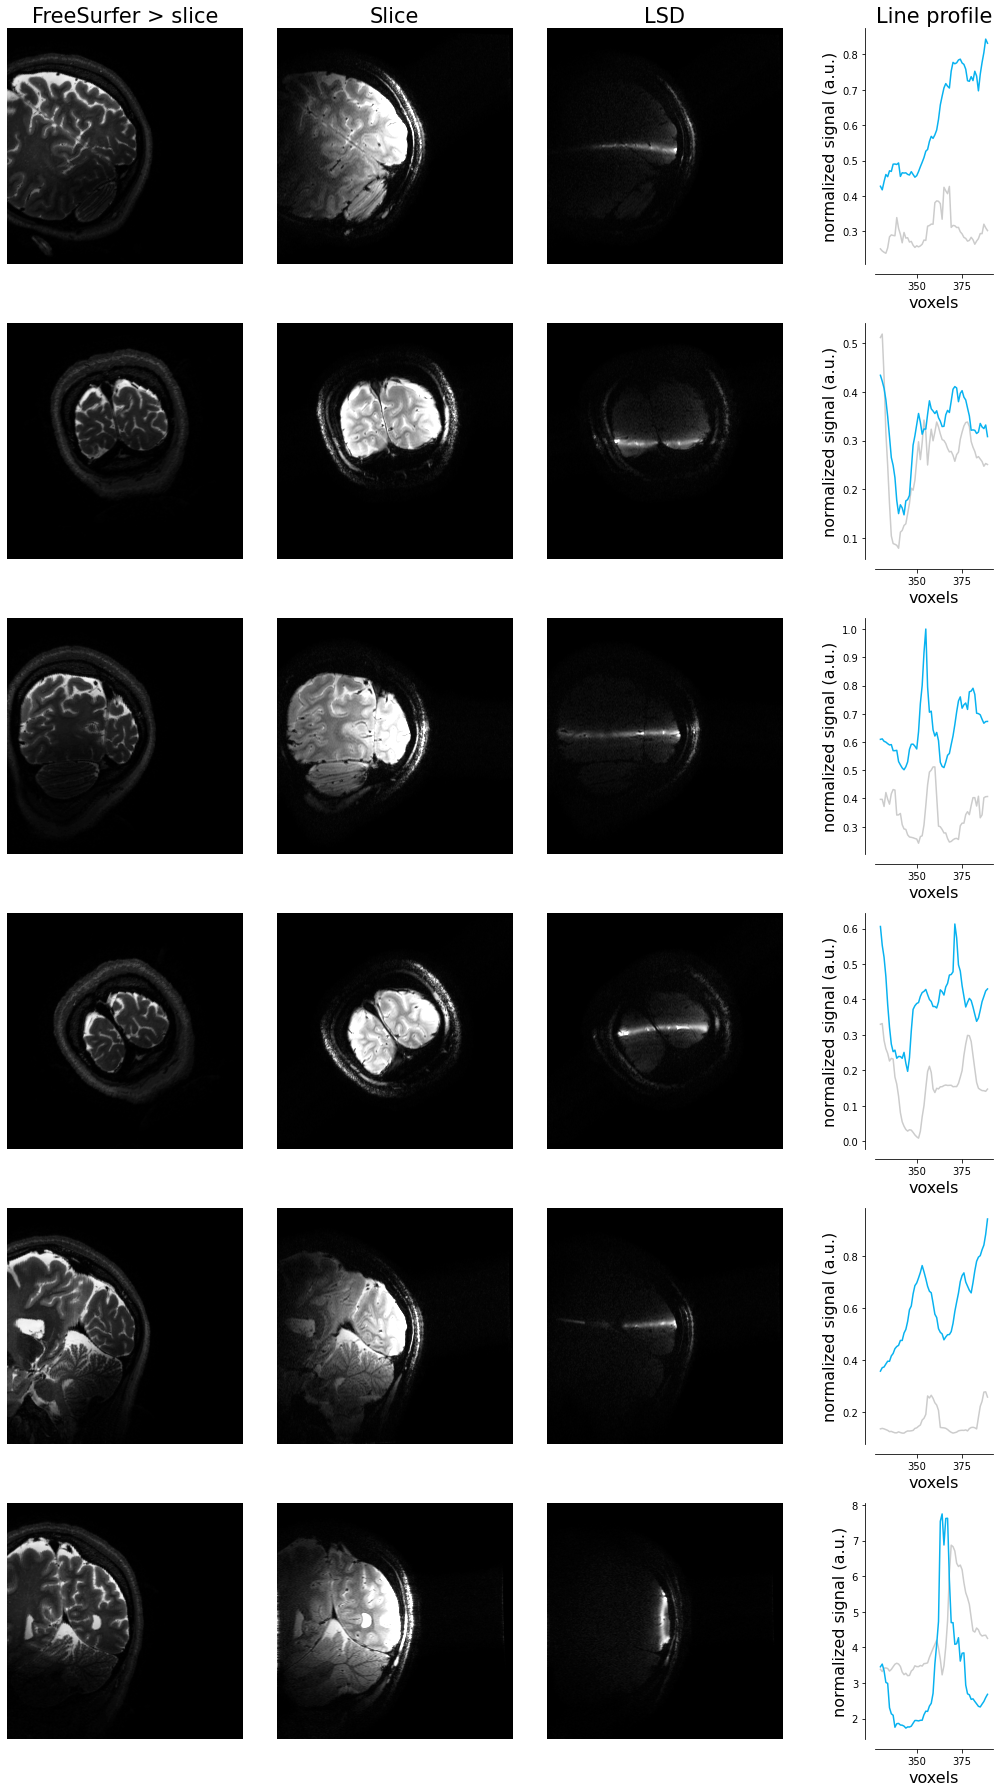

In [5]:
sub = 'sub-006'
fold = ['FH','FH','FH','FH','FH','LR']
mdd_color = "#08B2F0"
con_color = "#cccccc"

fig,axs = plt.subplots(6,4,figsize=(15,25), constrained_layout=True, facecolor="white")

for ii in range(1,7):
    
    pred = utils.get_file_from_substring(f"run-{ii}_orig_T2w.nii.gz", opj(base_dir, 'derivatives', 'confirm', sub))
    print(pred)
    pred_img = nb.load(pred)
    pred_data = np.squeeze(np.squeeze(pred_img.get_fdata()))

    real = utils.get_file_from_substring(f"run-{ii}_T1w.nii.gz", opj(base_dir, sub, 'ses-2', 'anat'))
    real_img = nb.load(real)
    real_data = np.squeeze(np.squeeze(real_img.get_fdata()))

    recon = utils.get_file_from_substring(f"run-{ii}", opj(base_dir, sub, 'ses-2', 'recon'))
    recon_img = nb.load(recon)
    recon_data = np.squeeze(np.squeeze(recon_img.get_fdata()))

    axs[ii-1][0].imshow(np.rot90(pred_data), cmap="Greys_r")
    
    # more coronal slices have higher signal intensities, so need different windowing
    if ii == 2 or ii == 4:
        axs[ii-1][1].imshow(np.rot90(real_data), cmap="Greys_r", vmin=0, vmax=2400)
    else:
        axs[ii-1][1].imshow(np.rot90(real_data), cmap="Greys_r", vmin=0, vmax=1500)

    axs[ii-1][2].imshow(np.rot90(recon_data), cmap="Greys_r", vmin=0, vmax=1500)

    if fold[ii-1] == "FH":

        xx = np.arange(330,390,1)

        # get average over beam (16x720)
        real_line_avg = np.mean(real_data[...,352:368],axis=-1)/np.max(np.mean(real_data[...,352:368],axis=-1))
        pred_line_avg = np.mean(pred_data[...,352:368],axis=-1)/np.max(np.mean(pred_data[...,352:368],axis=-1))

        # print(pred_data[...,352:368].shape)

        # plot middle 60 voxels
        axs[ii-1][3].plot(xx,pred_line_avg[330:390], color=con_color, label="predicted")
        axs[ii-1][3].plot(xx,real_line_avg[330:390], color=mdd_color, label="real")

        asp = np.diff(axs[ii-1][3].get_xlim())[0] / np.diff(axs[ii-1][3].get_ylim())[0]
        axs[ii-1][3].set_aspect(asp*2)
    else:

        xx = np.arange(330,390,1)

        # get average over beam (16x720)
        real_line_avg = np.mean(pred_data[352:368,...],axis=0)/np.max(np.mean(pred_data[352:368,...],axis=-1))
        pred_line_avg = np.mean(real_data[352:368,...],axis=0)/np.max(np.mean(real_data[352:368,...],axis=-1))

        # plot middle 60 voxels
        axs[ii-1][3].plot(xx,pred_line_avg[330:390], color=con_color, label="predicted")
        axs[ii-1][3].plot(xx,real_line_avg[330:390], color=mdd_color, label="real")
        
        asp = np.diff(axs[ii-1][3].get_xlim())[0] / np.diff(axs[ii-1][3].get_ylim())[0]
        axs[ii-1][3].set_aspect(asp*2)

    # vox_shift, corr_list, vox_range = get_shift(real_line_avg, pred_line_avg)
    # axs[ii-1][4].plot(vox_range, corr_list, color="#D01B47")
    # axs[ii-1][4].set_xlabel("padded voxels").set_fontsize(16)
    # axs[ii-1][4].set_ylabel("correlation").set_fontsize(16)
    # asp = np.diff(axs[ii-1][4].get_xlim())[0] / np.diff(axs[ii-1][4].get_ylim())[0]
    # axs[ii-1][4].set_aspect(asp*2)

    # axs[ii-1][0].axis('off')
    # axs[ii-1][0].set_ylabel(f"Slice {ii-1}").set_fontsize(16)
    axs[ii-1][0].axis('off')
    axs[ii-1][1].axis('off')
    axs[ii-1][2].axis('off')
    # axs[ii-1][3].axis('off')
    axs[ii-1][3].set_xlabel("voxels").set_fontsize(16)
    axs[ii-1][3].set_ylabel("normalized signal (a.u.)").set_fontsize(16)
    sns.despine(offset=10)

    axs[0][0].set_title("FreeSurfer > slice").set_fontsize(21)
    axs[0][1].set_title("Slice").set_fontsize(21)
    axs[0][2].set_title("LSD").set_fontsize(21)
    axs[0][3].set_title("Line profile").set_fontsize(21)
    # axs[0][4].set_title("Correlation").set_fontsize(21)

    
plt.tight_layout()
plt.savefig(opj(base_dir, 'derivatives', 'confirm', sub, "slice_confirmation_T2_noShift.pdf"))

(720, 720)


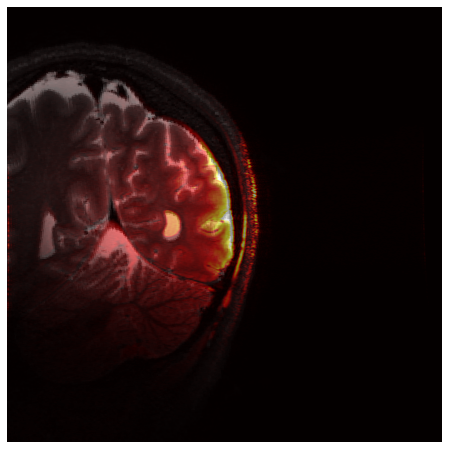

In [6]:
fig,axs = plt.subplots(figsize=(8,8))

print(pred_data.shape)
axs.imshow(np.rot90(pred_data), cmap="Greys_r")
axs.imshow(np.rot90(real_data), cmap="hot", vmin=0, vmax=4000, alpha=0.5)

axs.axis('off')
plt.show()

The Euclidean distance metric is essentially the vector norm between the two time series (vectors) and as such requires the two series to be of equal length. Its value can range from 0 (identical time series) to infinity, the actual output value not only depending on the similarity between two time series but also on their length / number of points compared.

In [7]:
def calc_euclidean(actual, predic):
    return np.sqrt(np.sum((actual - predic) ** 2))

def calc_mape(actual, predic):
    return np.mean(np.abs((actual - predic) / actual))    

diff_eucl = calc_euclidean(real_line_avg, pred_line_avg)
print(f"Euclidean difference = {diff_eucl}")

diff_mape = calc_mape(real_line_avg, pred_line_avg)
print(f"MAPE difference = {diff_mape}")

Euclidean difference = 23.253834586140826
MAPE difference = nan


In [8]:
# !pip install dtaidistance

(<Figure size 720x720 with 4 Axes>,
 [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>])

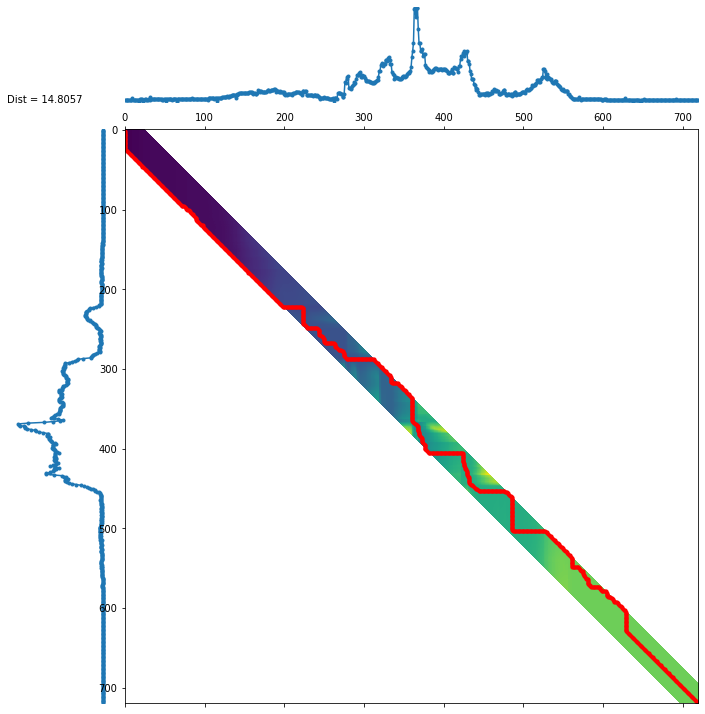

In [9]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random
import numpy as np
x = np.arange(0, 20, .5)
s1 = pred_line_avg.copy()
s2 = real_line_avg.copy()
random.seed(1)
for idx in range(len(s2)):
    if random.random() < 0.05:
        s2[idx] += (random.random() - 0.5) / 2
d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path)

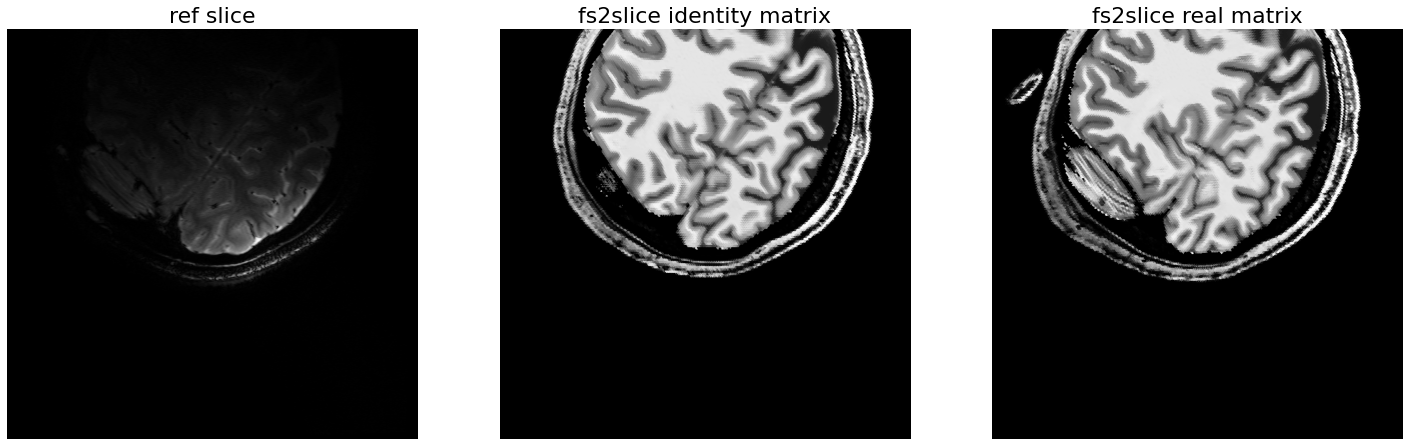

In [10]:
fig,axs = plt.subplots(1,3,figsize=(25,10))

pred = utils.get_file_from_substring(f"run-1_orig_T1w.nii.gz", opj(base_dir, 'derivatives', 'confirm', sub))
pred_img = nb.load(pred)
pred_data = np.squeeze(np.squeeze(pred_img.get_fdata()))

real = utils.get_file_from_substring(f"run-1_T1w.nii.gz", opj(base_dir, sub, 'ses-2', 'anat'))
real_img = nb.load(real)
real_data = np.squeeze(np.squeeze(real_img.get_fdata()))

ident = utils.get_file_from_substring(f"desc-ident", opj(base_dir, 'derivatives', 'confirm', sub))
ident_img = nb.load(ident)
ident_data = np.squeeze(np.squeeze(ident_img.get_fdata()))

axs[0].imshow(real_data, cmap="Greys_r")
axs[1].imshow(ident_data, cmap="Greys_r")
axs[2].imshow(pred_data, cmap="Greys_r")

axs[0].set_title('ref slice').set_fontsize(22)
axs[1].set_title('fs2slice identity matrix').set_fontsize(22)
axs[2].set_title('fs2slice real matrix').set_fontsize(22)

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

plt.show()

In [11]:
# ff = cortex.options.usercfg
# print(ff)
# ! cat $ff

In [12]:
# # test_vol2surf = utils.get_file_from_substring("sub-006_hemi-LR_space-fsnative_desc-T1w", opj(base_dir, 'derivatives', 'freesurfer', 'sub-006', 'mri'))

# # call_vol2fsaverage sub-006 sub-006_ses-line_acq-1slice_run-2_space-fs_desc-recon.nii.gz recon2
# test_vol2surf = utils.get_file_from_substring("hemi-LR_space-fsnative_desc-recon2", opj(base_dir, 'derivatives', 'freesurfer', 'sub-006', 'mri'))
# print(test_vol2surf)

# test_vol2surf = np.load(test_vol2surf)
# test_vol2surf_vert = cortex.Vertex(test_vol2surf, 'sub-006', cmap='viridis')
# cortex.webshow(test_vol2surf_vert)

# Iterative registration

In [33]:
from scipy.spatial.transform import Rotation as R

mov = utils.get_file_from_substring("orig.nii.gz", opj(base_dir, 'derivatives', 'freesurfer', sub, 'mri'))
ref = utils.get_file_from_substring("sub-006_ses-2_acq-MP2RAGE_T1w.nii.gz", opj(base_dir, sub, 'ses-2', 'anat'))
print(mov)
print(ref)

warp = utils.get_file_from_substring("from-fs_to-ses2", opj(base_dir, 'derivatives', 'pycortex', sub, 'transforms'))

avg_warp = np.zeros((4,4,100))
avg_angle = np.zeros((100,3))
for ii in range(100):

    out = opj(base_dir, 'derivatives', 'confirm', sub, 'iter_transform', f"iter{ii}_desc-")
    if not os.path.exists(out+'genaff.mat'):
        print(f"Iteration {ii}..")
        os.system(f"call_antsregistration {ref} {mov} {out} rigid")
    ll = utils.get_matrixfromants(out+'genaff.mat')
    avg_warp[...,ii] = ll

    mat = R.from_matrix(ll[:3,:3])  
    avg_angle[ii,...] = mat.as_euler('zyx', degrees=True)

# avg_warp = np.concatenate(avg_warp)
avg_warp[...,0]

/data1/projects/MicroFunc/Jurjen/projects/linePlanning/derivatives/freesurfer/sub-006/mri/orig.nii.gz
/data1/projects/MicroFunc/Jurjen/projects/linePlanning/sub-006/ses-2/anat/sub-006_ses-2_acq-MP2RAGE_T1w.nii.gz


array([[ 0.999,  0.011, -0.032,  1.63 ],
       [-0.009,  0.997,  0.071, -1.917],
       [ 0.033, -0.071,  0.997,  4.427],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

In [34]:
avg_angle.shape

(100, 3)

mean coordinate = [ 1.628 -1.926  4.409]
sem coordinate = [0.001 0.001 0.001]
std coordinate = [0.008 0.012 0.015]


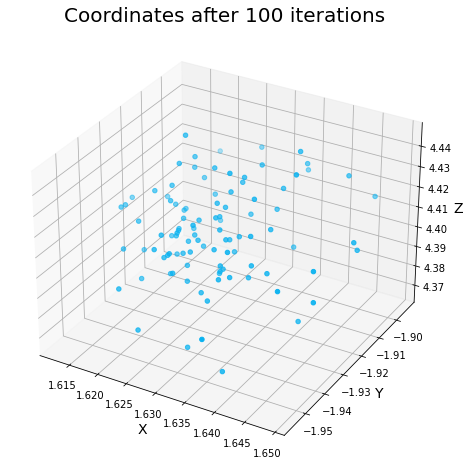

saved /data1/projects/MicroFunc/Jurjen/projects/linePlanning/derivatives/confirm/sub-006/position_and_angle.csv


In [40]:
from scipy.stats import sem
pos = np.array([avg_warp[:,-1,i][:3] for i in range(100)])
pos.mean(axis=0)
print(f'mean coordinate = {pos.mean(axis=0)}')
print(f'sem coordinate = {sem(pos,axis=0)}')
print(f'std coordinate = {pos.std(axis=0)}')

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(pos[...,0],pos[...,1],pos[...,2], color=mdd_color)

ax.set_xlabel('X').set_fontsize(14)
ax.set_ylabel('Y').set_fontsize(14)
ax.set_zlabel('Z').set_fontsize(14)

ax.set_title("Coordinates after 100 iterations").set_fontsize(20)

plt.show()

full = np.hstack((pos, avg_angle))

df = pd.DataFrame(full, columns=['x_trans', 'y_trans', 'z_trans', 'z_angle', 'y_angle', 'x_angle'])

fname = opj(base_dir, 'derivatives', 'confirm', sub, 'position_and_angle.csv')
df.to_csv(fname, index=False)
# np.savetxt(fname, pos, delimiter=",")
print(f"saved {fname}")

In [32]:
pos.shape

(100, 3)

In [27]:
from scipy.spatial.transform import Rotation as R
mat = R.from_matrix(utils.get_matrixfromants(warp)[:3,:3])
mat.as_euler('zyx', degrees=True).shape

(3,)